In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM, using both 1day Adjusted Close Parameters
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Merge
from keras.layers import Activation, Dropout
from keras.metrics import mean_squared_error

# Import fix for Tensorflow 1.0 control flow ops w/ Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '2014-04-01', '2017-04-01'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'
tick_4 = 'TSLA'
tick_5 = 'AMZN'
tick_6 = 'GOOG'
tick_7 = 'NVDA'

# Set Baseline Model Ticker
base_ticker = tick_7

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close    Volume
0     0  2014-04-01  17.909576  16406800
1     1  2014-04-02  17.794341   5998700
2     2  2014-04-03  17.986400  14988700
3     3  2014-04-04  17.429427   9200800
4     4  2014-04-07  17.487044  10714400
---
     Item        Date   Adj_Close    Volume
752   752  2017-03-27  108.250000  12649300
753   753  2017-03-28  107.690002  10801700
754   754  2017-03-29  107.339996   8698700
755   755  2017-03-30  109.400002  13079800
756   756  2017-03-31  108.930000  10999400


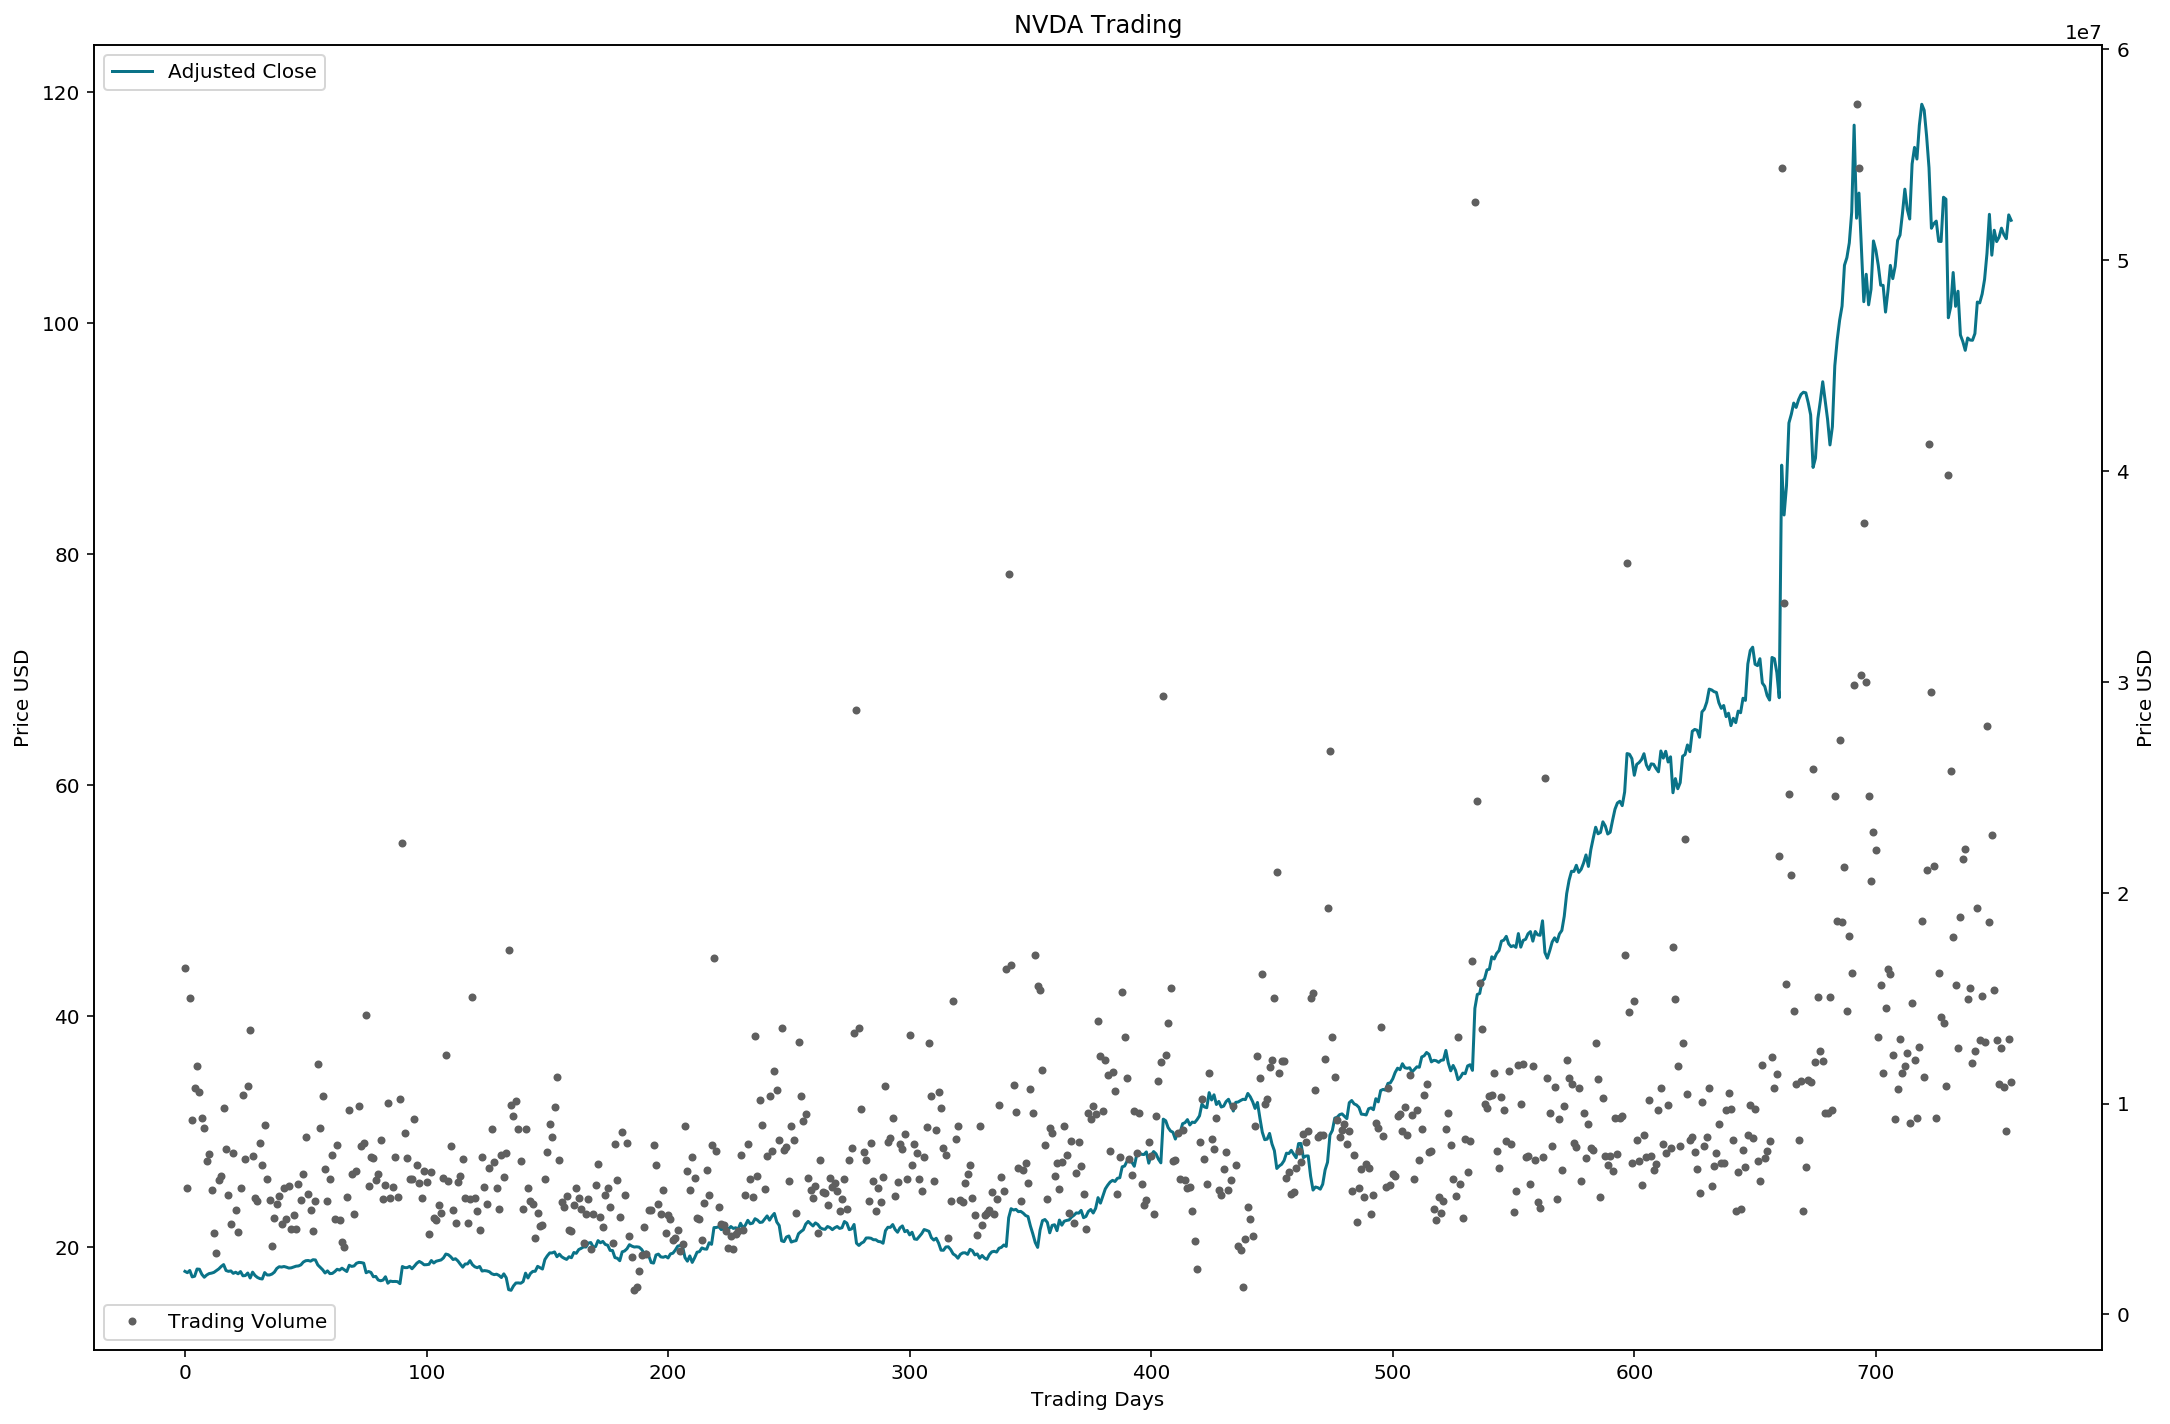

In [4]:
# Plot Basic Data
fig, ax1 = plt.subplots()
# Axis 1 - Adjusted Close
ax1.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')
# Set X Axis label
ax1.set_xlabel('Trading Days')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(stock_df['Item'], stock_df['Volume'], 'r.', color='#5f5f5f', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

# Add title and legend
ax1.set_title(base_ticker + ' Trading')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()

In [5]:
#Create numpy arrays for features and targets
day_all = []
vol_all = []
close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    day_all.append([(row['Item'])])
    vol_all.append([(row['Volume'])])
    close_all.append([(row['Adj_Close'])])
    
pprint(close_all)

[[17.909576],
 [17.794341],
 [17.9864],
 [17.429427],
 [17.487044],
 [18.11124],
 [18.092033999999998],
 [17.650295],
 [17.400619],
 [17.592678],
 [17.717518],
 [17.755929000000002],
 [17.823149],
 [17.967194],
 [18.120843],
 [18.332107999999998],
 [18.495359],
 [17.9864],
 [17.909576],
 [17.947989],
 [17.736722],
 [17.832752],
 [17.698311],
 [17.89037],
 [17.525457],
 [17.544663],
 [17.765532],
 [17.333396],
 [17.842356],
 [17.554267000000003],
 [17.381413000000002],
 [17.285382000000002],
 [17.246969],
 [17.803945000000002],
 [17.596528],
 [17.596528],
 [17.673704999999998],
 [17.837708],
 [18.156066],
 [18.310422],
 [18.281481],
 [18.329716],
 [18.271834],
 [18.194656],
 [18.213949],
 [18.291127],
 [18.358659],
 [18.377952],
 [18.474424],
 [18.715605],
 [18.831372],
 [18.850667],
 [18.792783],
 [18.918197],
 [18.898903],
 [18.464776999999998],
 [18.262186],
 [18.049946],
 [17.770178],
 [17.953475],
 [17.712295],
 [17.731588000000002],
 [17.885945],
 [18.088535999999998],
 [18.021006

In [6]:
# Reshape into t and t+1
look_back = 1
tt_split = (1.0-.315)

X_close_train, y_close_train, X_close_test, y_close_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)
    
pprint(X_close_train)
print('--')
pprint(y_close_train)

array([[[ 0.01596956]],

       [[ 0.01484762]],

       [[ 0.01671753]],

       [[ 0.01129478]],

       [[ 0.01185575]],

       [[ 0.01793299]],

       [[ 0.01774599]],

       [[ 0.01344518]],

       [[ 0.01101431]],

       [[ 0.01288421]],

       [[ 0.01409967]],

       [[ 0.01447364]],

       [[ 0.0151281 ]],

       [[ 0.01653054]],

       [[ 0.01802648]],

       [[ 0.02008338]],

       [[ 0.02167281]],

       [[ 0.01671753]],

       [[ 0.01596956]],

       [[ 0.01634356]],

       [[ 0.01428664]],

       [[ 0.0152216 ]],

       [[ 0.01391267]],

       [[ 0.01578257]],

       [[ 0.01222974]],

       [[ 0.01241673]],

       [[ 0.01456714]],

       [[ 0.01035982]],

       [[ 0.0153151 ]],

       [[ 0.01251024]],

       [[ 0.01082732]],

       [[ 0.00989235]],

       [[ 0.00951835]],

       [[ 0.01494113]],

       [[ 0.0129217 ]],

       [[ 0.0129217 ]],

       [[ 0.0136731 ]],

       [[ 0.01526985]],

       [[ 0.01836942]],

       [[ 0.01987224]],



In [7]:
pprint(np.shape(X_close_train))
pprint(np.shape(X_close_test))

pprint(X_close_train)

pprint(y_close_train)

(517, 1, 1)
(238, 1, 1)
array([[[ 0.01596956]],

       [[ 0.01484762]],

       [[ 0.01671753]],

       [[ 0.01129478]],

       [[ 0.01185575]],

       [[ 0.01793299]],

       [[ 0.01774599]],

       [[ 0.01344518]],

       [[ 0.01101431]],

       [[ 0.01288421]],

       [[ 0.01409967]],

       [[ 0.01447364]],

       [[ 0.0151281 ]],

       [[ 0.01653054]],

       [[ 0.01802648]],

       [[ 0.02008338]],

       [[ 0.02167281]],

       [[ 0.01671753]],

       [[ 0.01596956]],

       [[ 0.01634356]],

       [[ 0.01428664]],

       [[ 0.0152216 ]],

       [[ 0.01391267]],

       [[ 0.01578257]],

       [[ 0.01222974]],

       [[ 0.01241673]],

       [[ 0.01456714]],

       [[ 0.01035982]],

       [[ 0.0153151 ]],

       [[ 0.01251024]],

       [[ 0.01082732]],

       [[ 0.00989235]],

       [[ 0.00951835]],

       [[ 0.01494113]],

       [[ 0.0129217 ]],

       [[ 0.0129217 ]],

       [[ 0.0136731 ]],

       [[ 0.01526985]],

       [[ 0.01836942]],

 

In [8]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Set up hyperparameters
batch_size = 1
epochs = 5 # 200
n_nodes = [128]

# Create two branches of LSTM model

# Create LSTM Adjusted Close network - 1 day tracker 
model = Sequential()
model.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
print 'compilation time : ', time.time() - start

compilation time :  0.0859839916229


In [9]:
# Format inputs
train_inputs = X_close_train

# Train the model
model.fit(train_inputs, 
                y_close_train, 
                nb_epoch=epochs, 
                batch_size=batch_size, 
                verbose=2,
                validation_split=0.05
                )

Train on 491 samples, validate on 26 samples
Epoch 1/5
1s - loss: 6.7372e-04 - val_loss: 2.1480e-04
Epoch 2/5
1s - loss: 2.6842e-05 - val_loss: 1.7434e-05
Epoch 3/5
1s - loss: 2.7564e-05 - val_loss: 1.8091e-05
Epoch 4/5
1s - loss: 2.8953e-05 - val_loss: 1.6203e-05
Epoch 5/5
1s - loss: 3.0543e-05 - val_loss: 1.7524e-05


In [10]:
# Format inputs
test_inputs = X_close_test

# Generate predictions for training
testPredict = model.predict(test_inputs, batch_size=batch_size)
#testPredict = util.predict_sequences(model, test_inputs)

pprint(testPredict)
print(np.shape(X_close_test))

array([[ 0.19396888],
       [ 0.19358236],
       [ 0.19223   ],
       [ 0.19396888],
       [ 0.1942587 ],
       [ 0.20228431],
       [ 0.19155388],
       [ 0.18508729],
       [ 0.18962276],
       [ 0.18547316],
       [ 0.17766508],
       [ 0.17968829],
       [ 0.18315849],
       [ 0.18267642],
       [ 0.18923663],
       [ 0.19020207],
       [ 0.18547316],
       [ 0.23791046],
       [ 0.24970545],
       [ 0.25058374],
       [ 0.26113325],
       [ 0.26299113],
       [ 0.27062428],
       [ 0.27130967],
       [ 0.28187442],
       [ 0.28000572],
       [ 0.28472742],
       [ 0.28718814],
       [ 0.295266  ],
       [ 0.29615304],
       [ 0.29940739],
       [ 0.29290056],
       [ 0.2905362 ],
       [ 0.29142267],
       [ 0.2899451 ],
       [ 0.30177528],
       [ 0.29014218],
       [ 0.2959559 ],
       [ 0.29684323],
       [ 0.30157775],
       [ 0.30345294],
       [ 0.295266  ],
       [ 0.30355173],
       [ 0.30068985],
       [ 0.30029523],
       [ 0

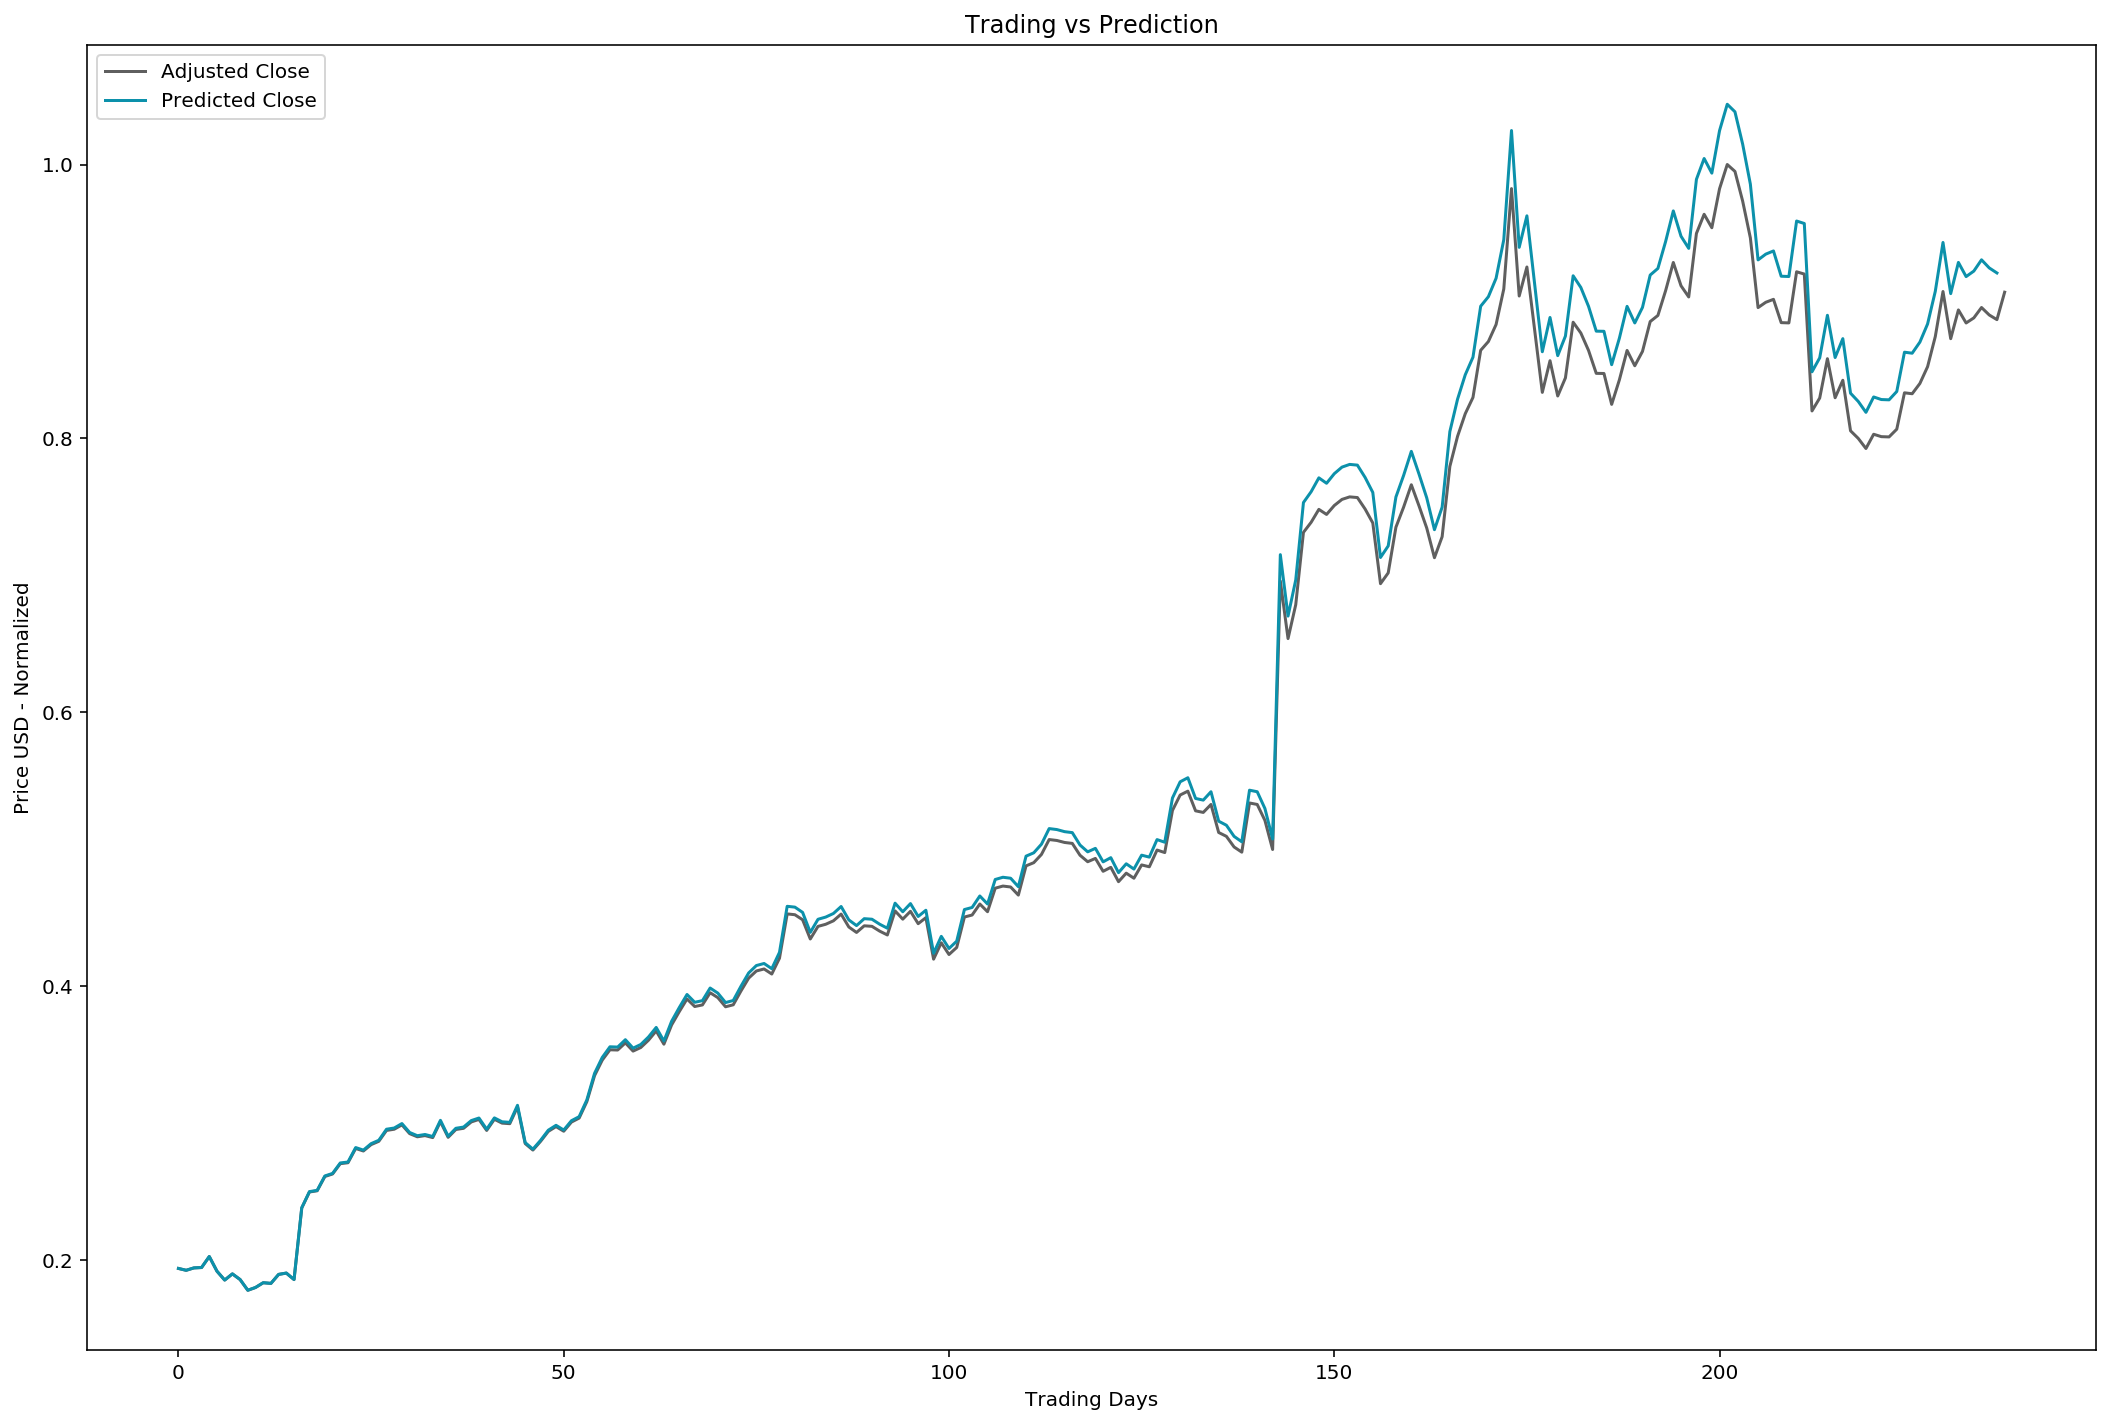

In [11]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

# Offset predictions by one day to align prediction and actual 
plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict[1:], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [12]:
# The mean squared error
testScore = model.evaluate(test_inputs, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

# Calculate the stock price delta in $
true_delta = testScore*(close_bounds[1]-close_bounds[0])
print('Delta Price: %.6f - RMSE * Adjusted Close Range' % true_delta)

Test Score: 0.000861 MSE (0.029351 RMSE)
Delta Price: 0.088481 - RMSE * Adjusted Close Range


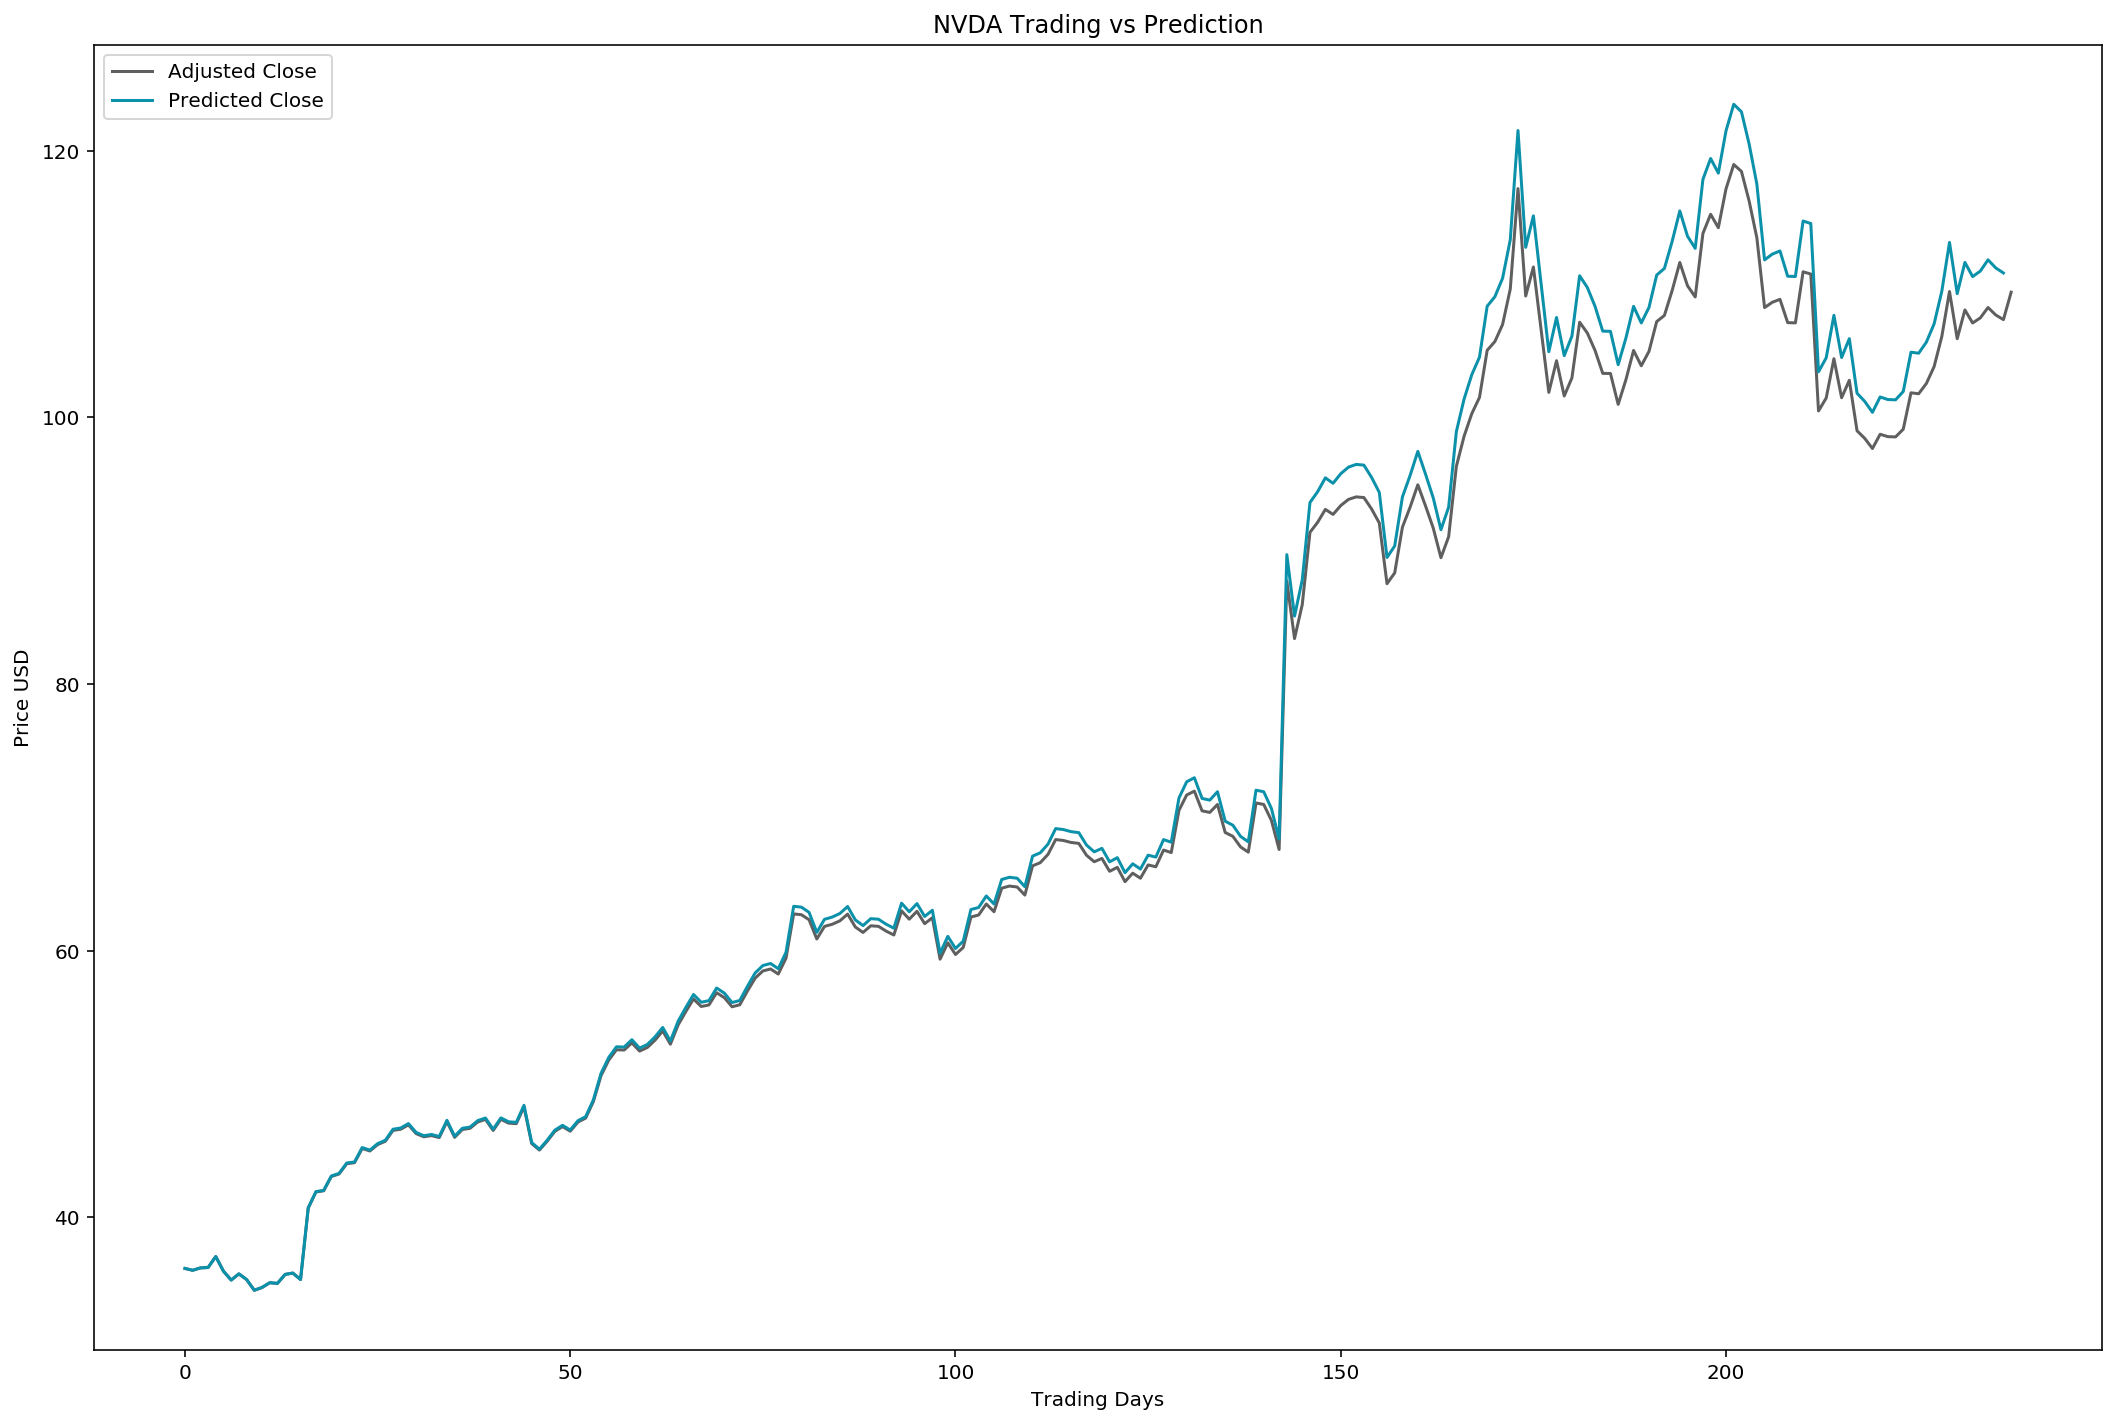

In [13]:
# Plot the predictions
#close_plot = close_all[-ya_close_test.shape[0]:]

close_seq = np.array(y_close_test)
pred_seq = np.array(testPredict)

#pprint(pred_seq)
close_seq_plot, r = util.scale_range(y_close_test, input_range=[0.0,1.0], target_range=close_bounds)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

# Offset predictions by one day to align prediction and actual 
plt.plot(close_seq_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot[1:], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

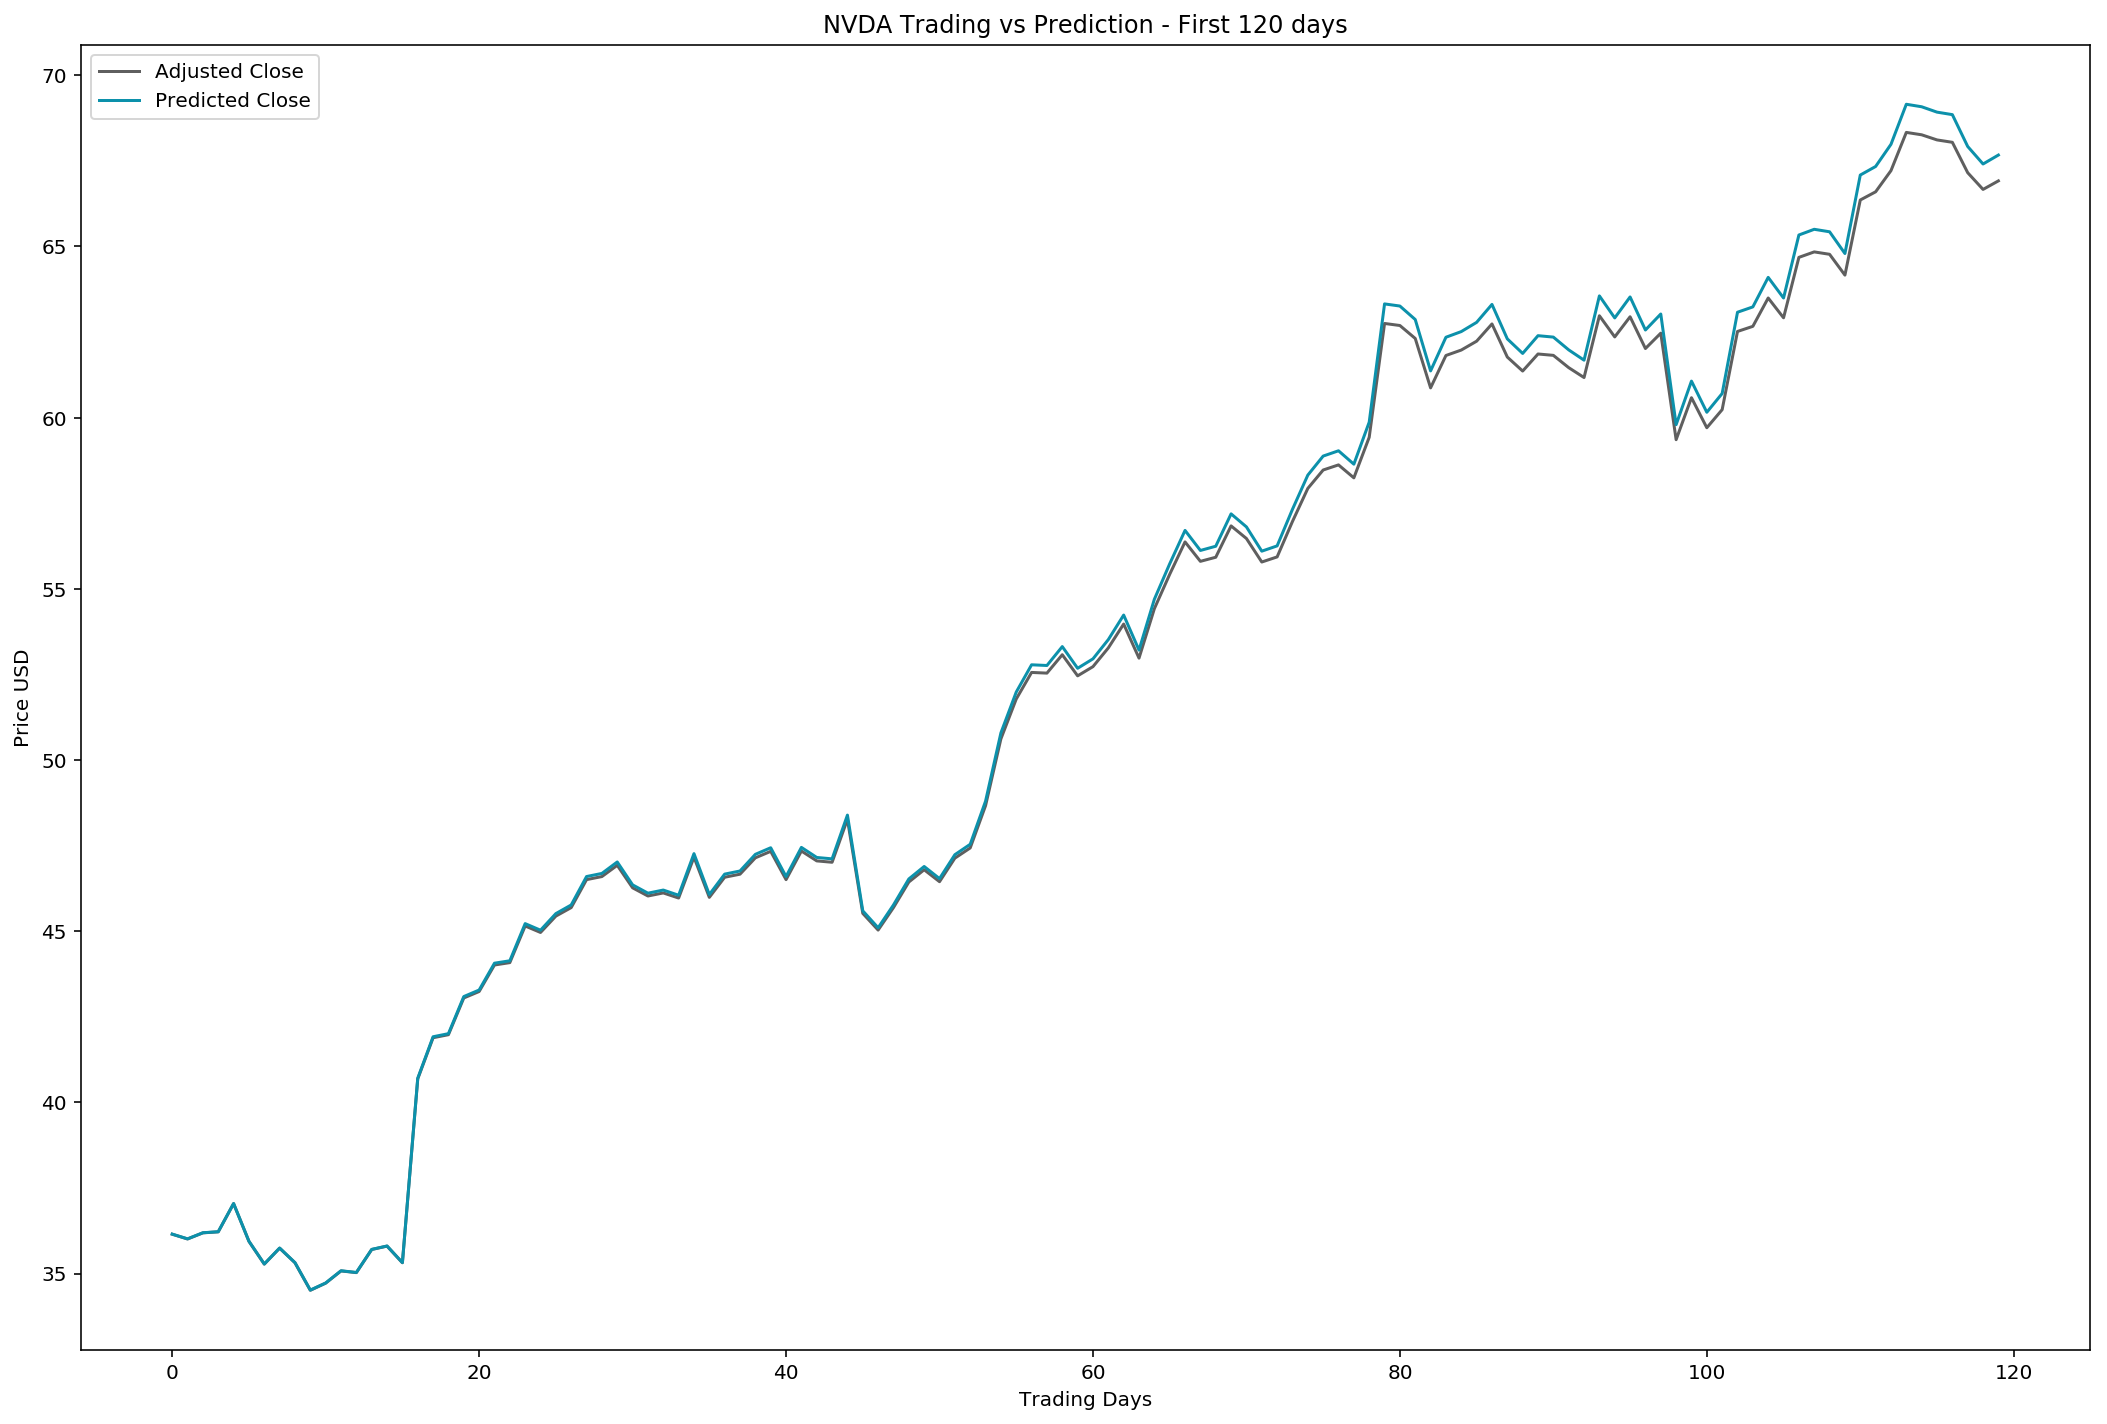

In [14]:
# Plot the predictions first 120 days (6 months of trading)
subspan = 120
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

# Offset predictions by one day to align prediction and actual 
plt.plot(close_seq_plot[:subspan],'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot[1:subspan+1], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction - First 120 days')
ax.legend(loc='upper left')

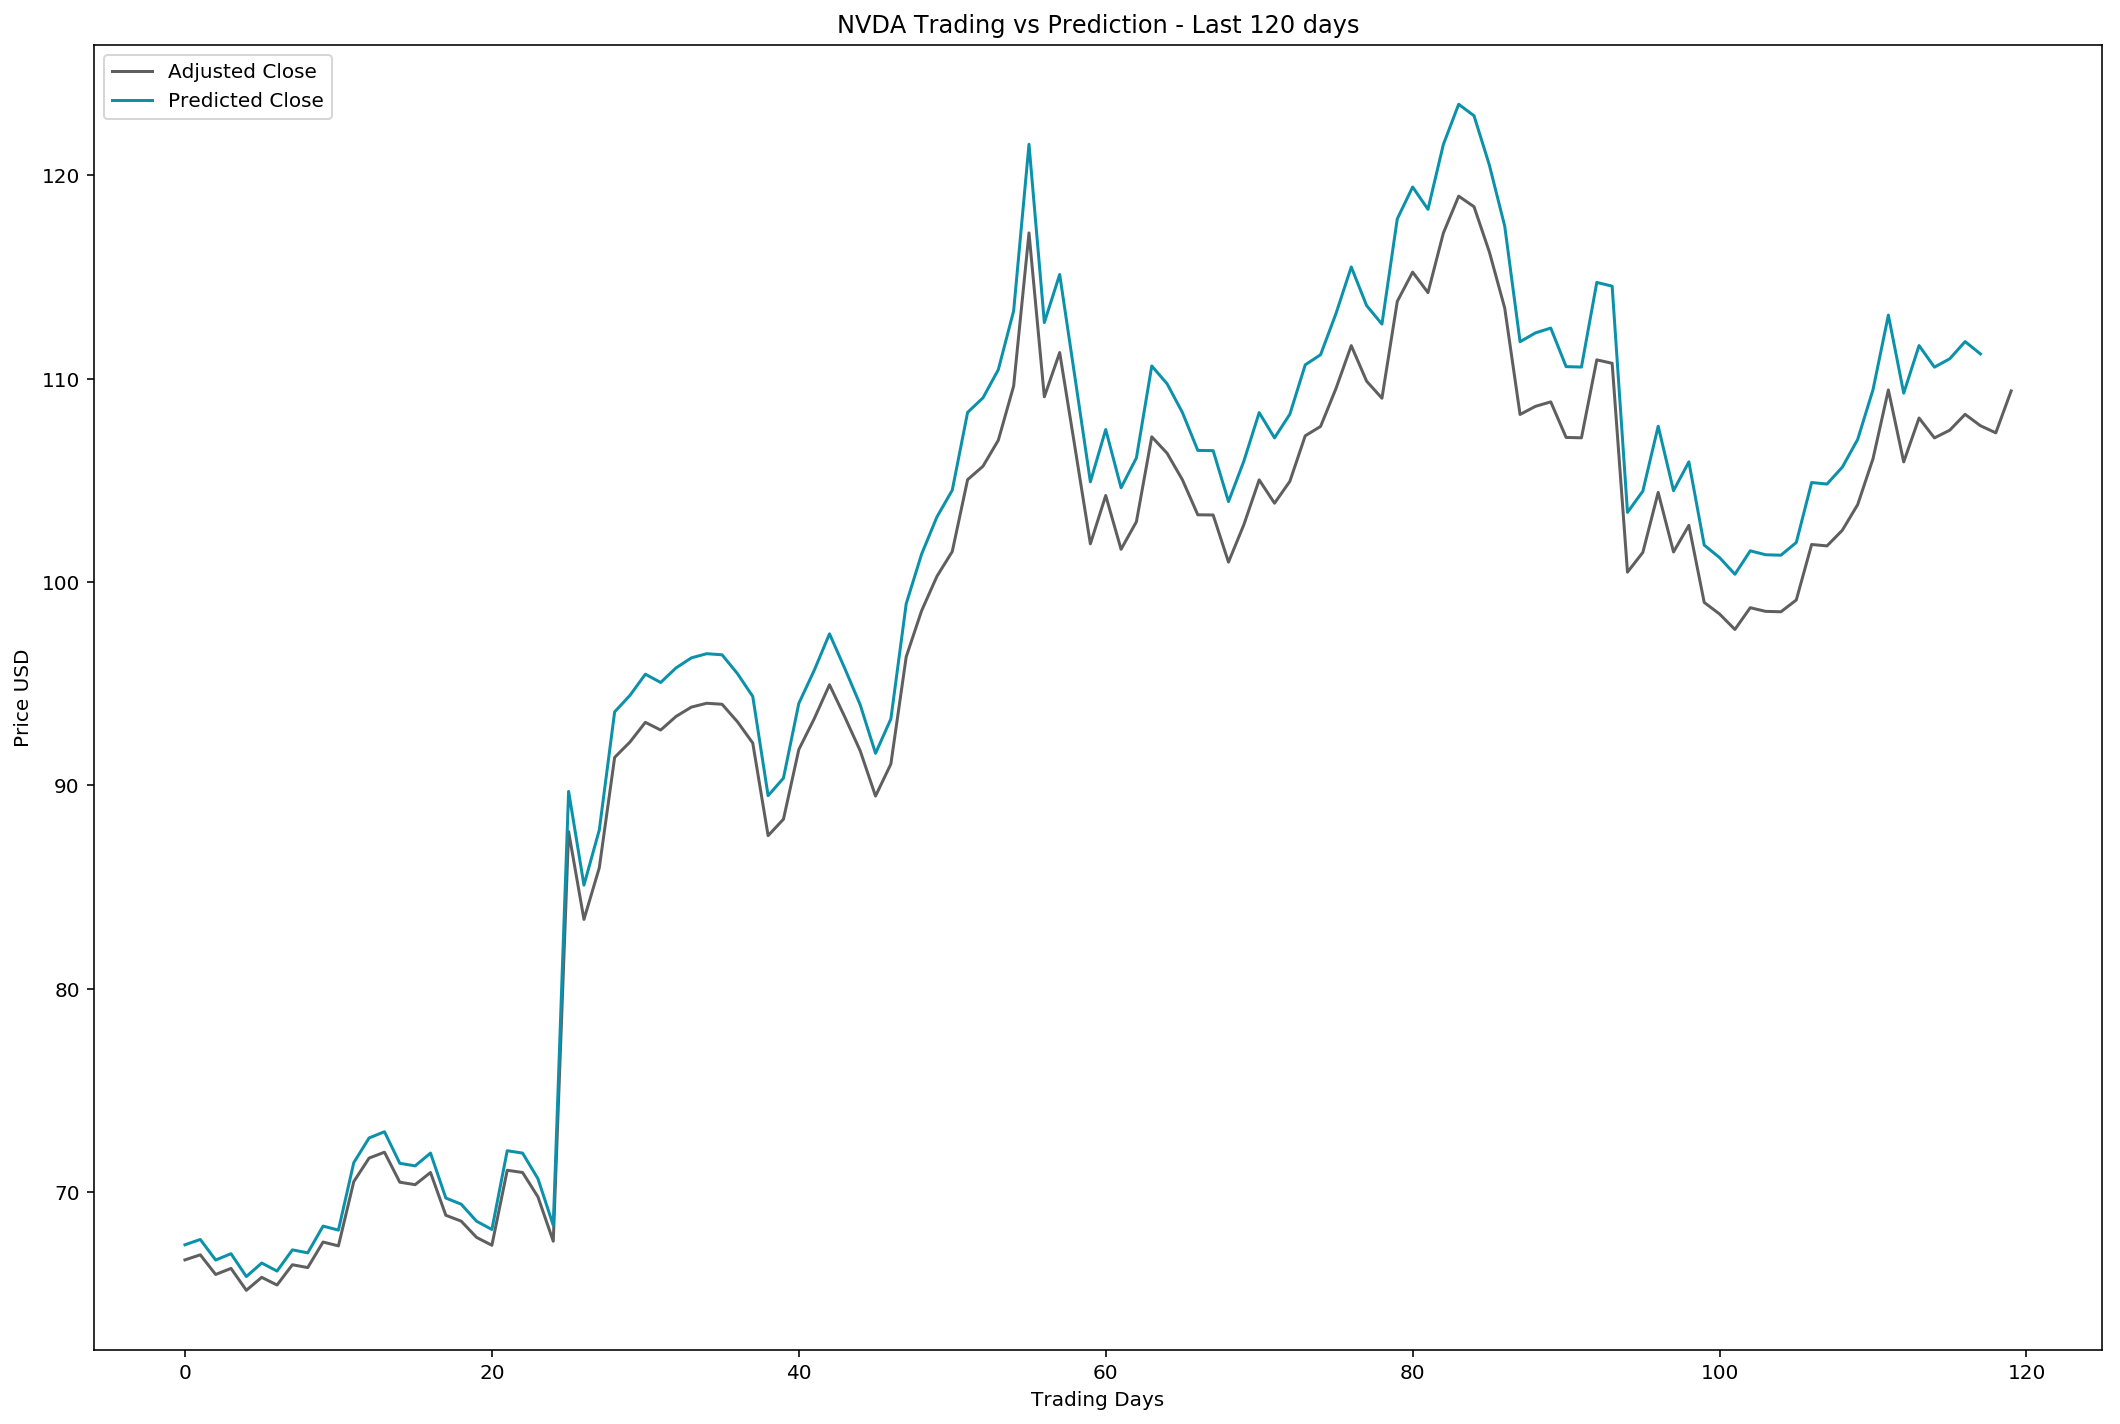

In [15]:
# Plot the predictions last 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

# Offset predictions by one day to align prediction and actual 
plt.plot(close_seq_plot[-subspan:],'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot[-(subspan-1):-1], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction - Last 120 days')
ax.legend(loc='upper left')

In [16]:
# Trading Algorithm

# Create a dataframe for stock data
trades_df = pd.DataFrame(columns=('Price','Prediction','PredDelta','State','Shares','IncShares','StockValue','Cash','Folio','IncSum','Performance'))
# Create variable for stock ownership
own = True

# Loop through trading days
for i in range(0, len(preds_seq_plot)-1):
    # Until the final day in sequence
    if i < len(preds_seq_plot)-2:
        # For first day, initiate trading
        if i == 0:
            start_price = close_seq_plot[0][0]
            trades_df.loc[i,'Price'] = start_price
            trades_df.loc[i,'Folio'] = 1000.0
            trades_df.loc[i,'State'] = 'Buy'
            trades_df.loc[i,'Shares'] = math.floor(trades_df.loc[i,'Folio']/start_price)
            trades_df.loc[i,'StockValue'] = trades_df.loc[i,'Shares']*start_price
            trades_df.loc[i,'Cash'] = trades_df.loc[i,'Folio']-trades_df.loc[i,'StockValue'] 
            trades_df.loc[i,'PredDelta'] = 0.0
            trades_df.loc[i,'IncSum'] = start_price
            trades_df.loc[i,'IncShares'] = trades_df.loc[i,'Shares']
            buy_price = start_price
            own = True
        # Otherwise, it's the end of the trading day and we decide on trade executed just after close
        else:
            # Get yesterday's closing price
            price_yest = close_seq_plot[i-1][0]
            # Get today's closing price
            price_today = close_seq_plot[i][0]
            
            # quick calc for sum of increase
            if price_today>price_yest:
                trades_df.loc[i,'IncSum'] = trades_df.loc[i-1,'IncSum']+price_today-price_yest
            else:
                trades_df.loc[i,'IncSum'] = trades_df.loc[i-1,'IncSum']
            
            # Get todays's prediction
            pred_today = preds_seq_plot[i+1][0]
            # Get tomorrow's prediction
            pred_tomorrow = preds_seq_plot[i+2][0]
            # Get delta price
            pred_delta = pred_tomorrow-pred_today
            # Store the price
            trades_df.loc[i,'Price'] = price_today
            # Store the prediction
            trades_df.loc[i,'Prediction'] = pred_tomorrow
            # Store prediction delta
            trades_df.loc[i,'PredDelta'] = pred_delta

            # If the stock is currently owned
            if own == True:    
                # If the projection is positive
                if pred_delta > 0:
                    # Hold the stock
                    trades_df.loc[i,'State'] = 'Hold'
                    trades_df.loc[i,'Shares'] = trades_df.loc[i-1,'Shares']
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']
                    own = True
                else:
                    # Sell the stock
                    trades_df.loc[i,'State'] = 'Sell'
                    trades_df.loc[i,'Shares'] = 0.0
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']+trades_df.loc[i-1,'Shares']*price_today
                    own = False
            # If the stock is not owned
            else:
                # If the projection is positive
                if pred_delta > 0:
                    # Buy the stock
                    trades_df.loc[i,'State'] = 'Buy'
                    # Store number of shares (cash/currentprice)
                    trades_df.loc[i,'Shares'] = math.floor(trades_df.loc[i-1,'Cash']/price_today)
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']-(trades_df.loc[i,'Shares']*price_today)
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i,'Shares']
                    own = True
                else:
                    # Set the state to pass on trading
                    trades_df.loc[i,'State'] = 'Pass'
                    # Update the number of shares to yesterdays
                    trades_df.loc[i,'Shares'] = 0.0
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']
                    own = False
            # Update Folio and Stock Value
            trades_df.loc[i,'StockValue'] = trades_df.loc[i,'Shares']*price_today
            trades_df.loc[i,'Folio'] =trades_df.loc[i,'StockValue']+trades_df.loc[i,'Cash']

    else:
        # Update last day since there aren't any more predictions
        trades_df.loc[i,'Price'] = close_seq_plot[i][0]
        trades_df.loc[i,'Folio'] = trades_df.loc[i-1,'Folio']
        trades_df.loc[i,'Shares'] = trades_df.loc[i-1,'Shares']
        trades_df.loc[i,'StockValue'] = trades_df.loc[i,'Price']*trades_df.loc[i,'Shares']
        trades_df.loc[i,'State'] = trades_df.loc[i-1,'State']
        trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
        trades_df.loc[i,'IncSum'] = trades_df.loc[i-1,'IncSum']
        trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']

trades_df['Performance'] = trades_df.loc[:,'Folio']/trades_df.loc[0,'Folio']
trades_df['NoLossMarketValue']=trades_df.loc[:,'IncSum']*trades_df.loc[0,'Shares']+trades_df.loc[0,'Cash']
trades_df['NoLossMarketPerform']=trades_df.loc[:,'NoLossMarketValue']/trades_df.loc[0,'NoLossMarketValue']
trades_df['MarketOpt']=trades_df.loc[:,'IncShares']*trades_df.loc[:,'IncSum']+trades_df.loc[0,'Cash']
trades_df['MarketOptPerform']=trades_df.loc[:,'MarketOpt']/trades_df.loc[0,'MarketOpt']
trades_df['InactiveValue']=trades_df.loc[0,'IncShares']*trades_df['Price']+trades_df.loc[0,'Cash']
trades_df['InactivePerform']=trades_df.loc[:,'InactiveValue']/trades_df.loc[0,'InactiveValue']

#close_seq_plot
#preds_seq_plot

pprint(trades_df)
trades_df.to_csv('logs/Study13-'+base_ticker+'.csv')

       Price Prediction  PredDelta State Shares IncShares StockValue     Cash  \
0    36.1491        NaN          0   Buy     27        27    976.025  23.9748   
1    36.0101     36.192   0.178604  Hold     27        27    972.272  23.9748   
2    36.1888    36.2217  0.0297661  Hold     27        27    977.098  23.9748   
3    36.2186    37.0461   0.824314  Hold     27        27    977.902  23.9748   
4    37.0426    35.9439   -1.10213  Sell      0        27          0  1024.13   
5    35.9406    35.2797  -0.664188  Pass      0        27          0  1024.13   
6    35.2754    35.7456   0.465839   Buy     29        29    1022.99  1.13965   
7     35.742    35.3194  -0.426208  Sell      0        29          0  1037.66   
8    35.3151    34.5174  -0.801971  Pass      0        29          0  1037.66   
9    34.5109    34.7252   0.207809   Buy     30        30    1035.33  2.33111   
10   34.7194    35.0816   0.356422  Hold     30        30    1041.58  2.33111   
11   35.0768    35.0321 -0.0

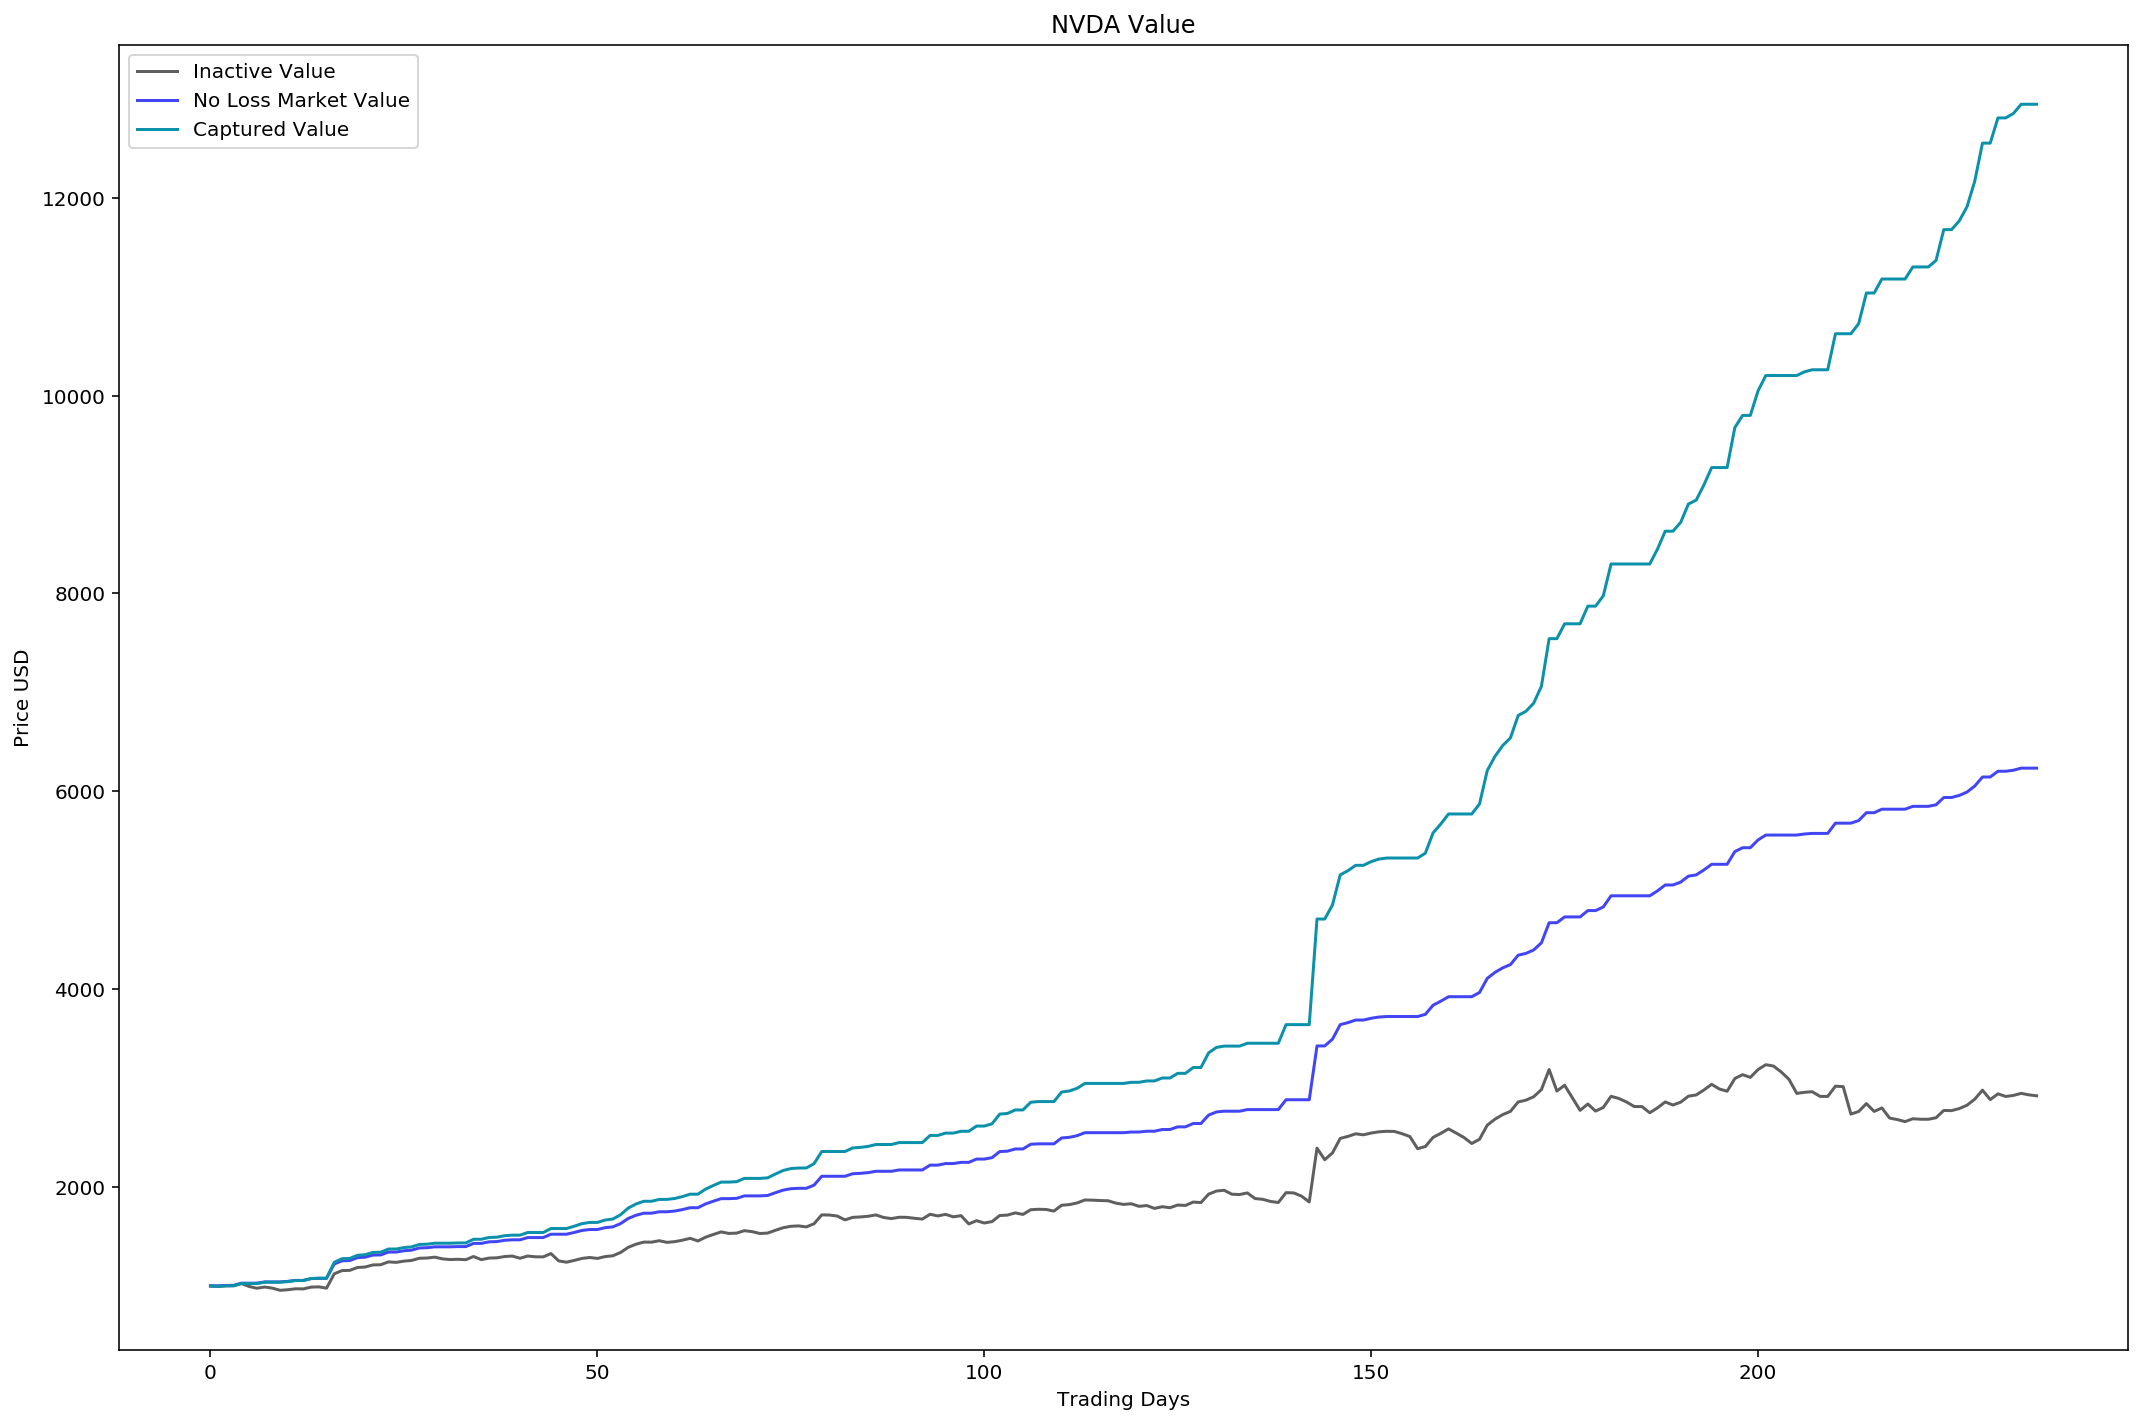

In [17]:
# Plot the stock price and captured value 

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[:,'InactiveValue'],'#5F5F5F', label='Inactive Value')
plt.plot(trades_df.loc[:,'NoLossMarketValue'], '#4245f4', label='No Loss Market Value')
#plt.plot(trades_df.loc[:,'MarketOpt'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[:,'Folio'], '#0C91AB', label='Captured Value')

# Set title
ax.set_title(base_ticker + ' Value')
ax.legend(loc='upper left')

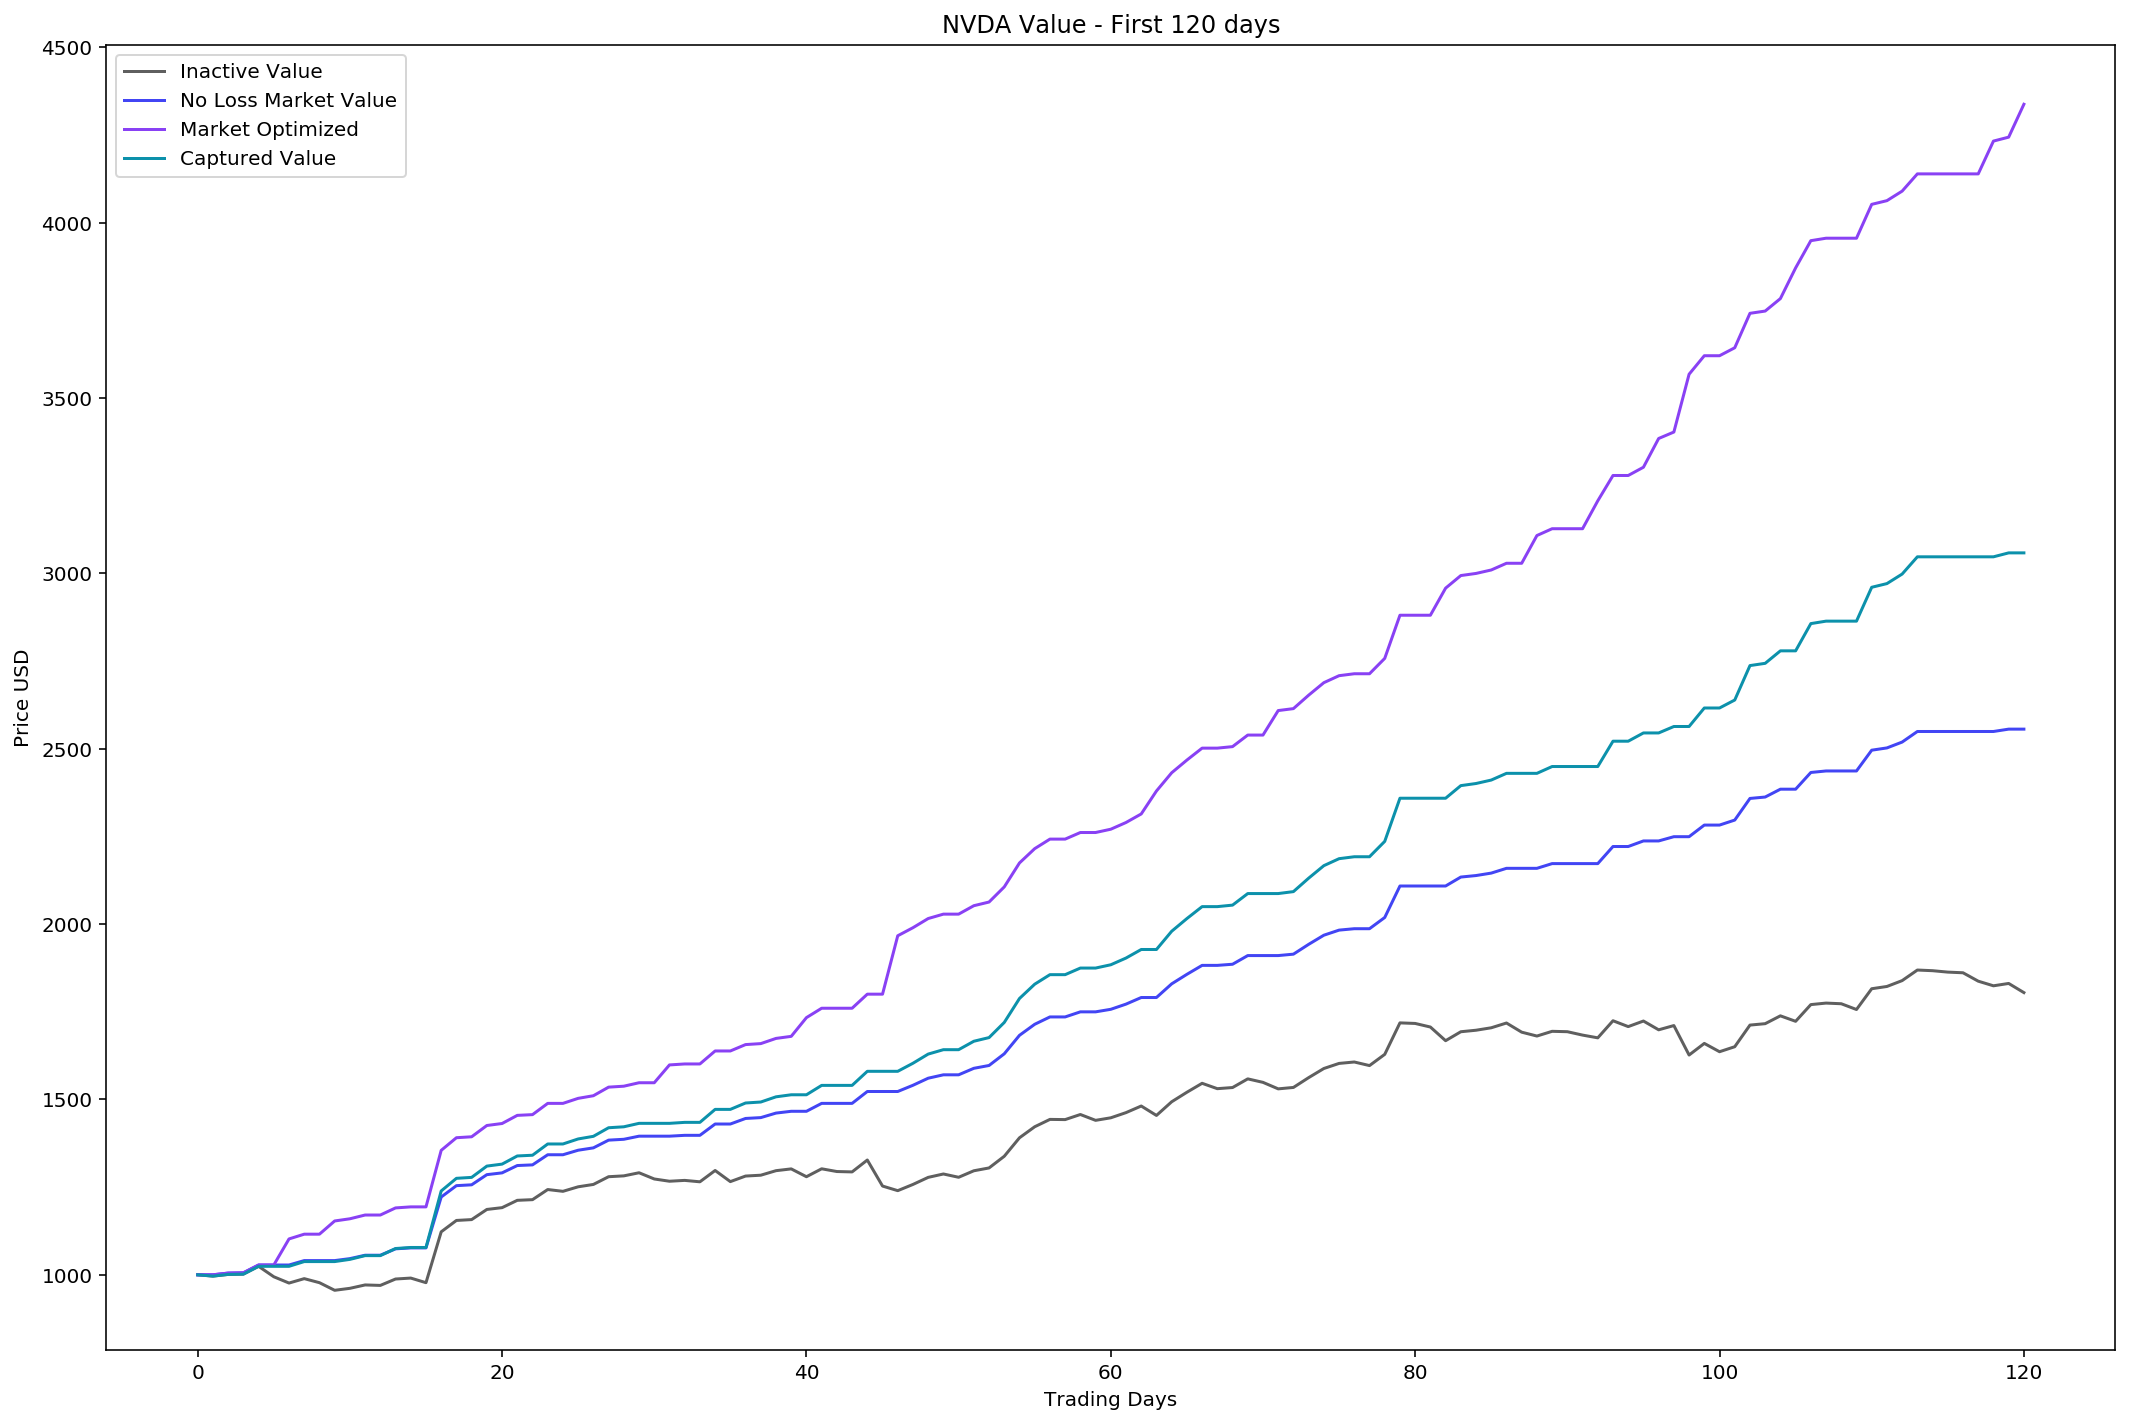

In [18]:
# Plot the stock price and captured value first 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[:120,'InactiveValue'],'#5F5F5F', label='Inactive Value')
plt.plot(trades_df.loc[:120,'NoLossMarketValue'], '#4245f4', label='No Loss Market Value')
plt.plot(trades_df.loc[:120,'MarketOpt'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[:120,'Folio'], '#0C91AB', label='Captured Value')

# Set title
ax.set_title(base_ticker + ' Value - First 120 days')
ax.legend(loc='upper left')

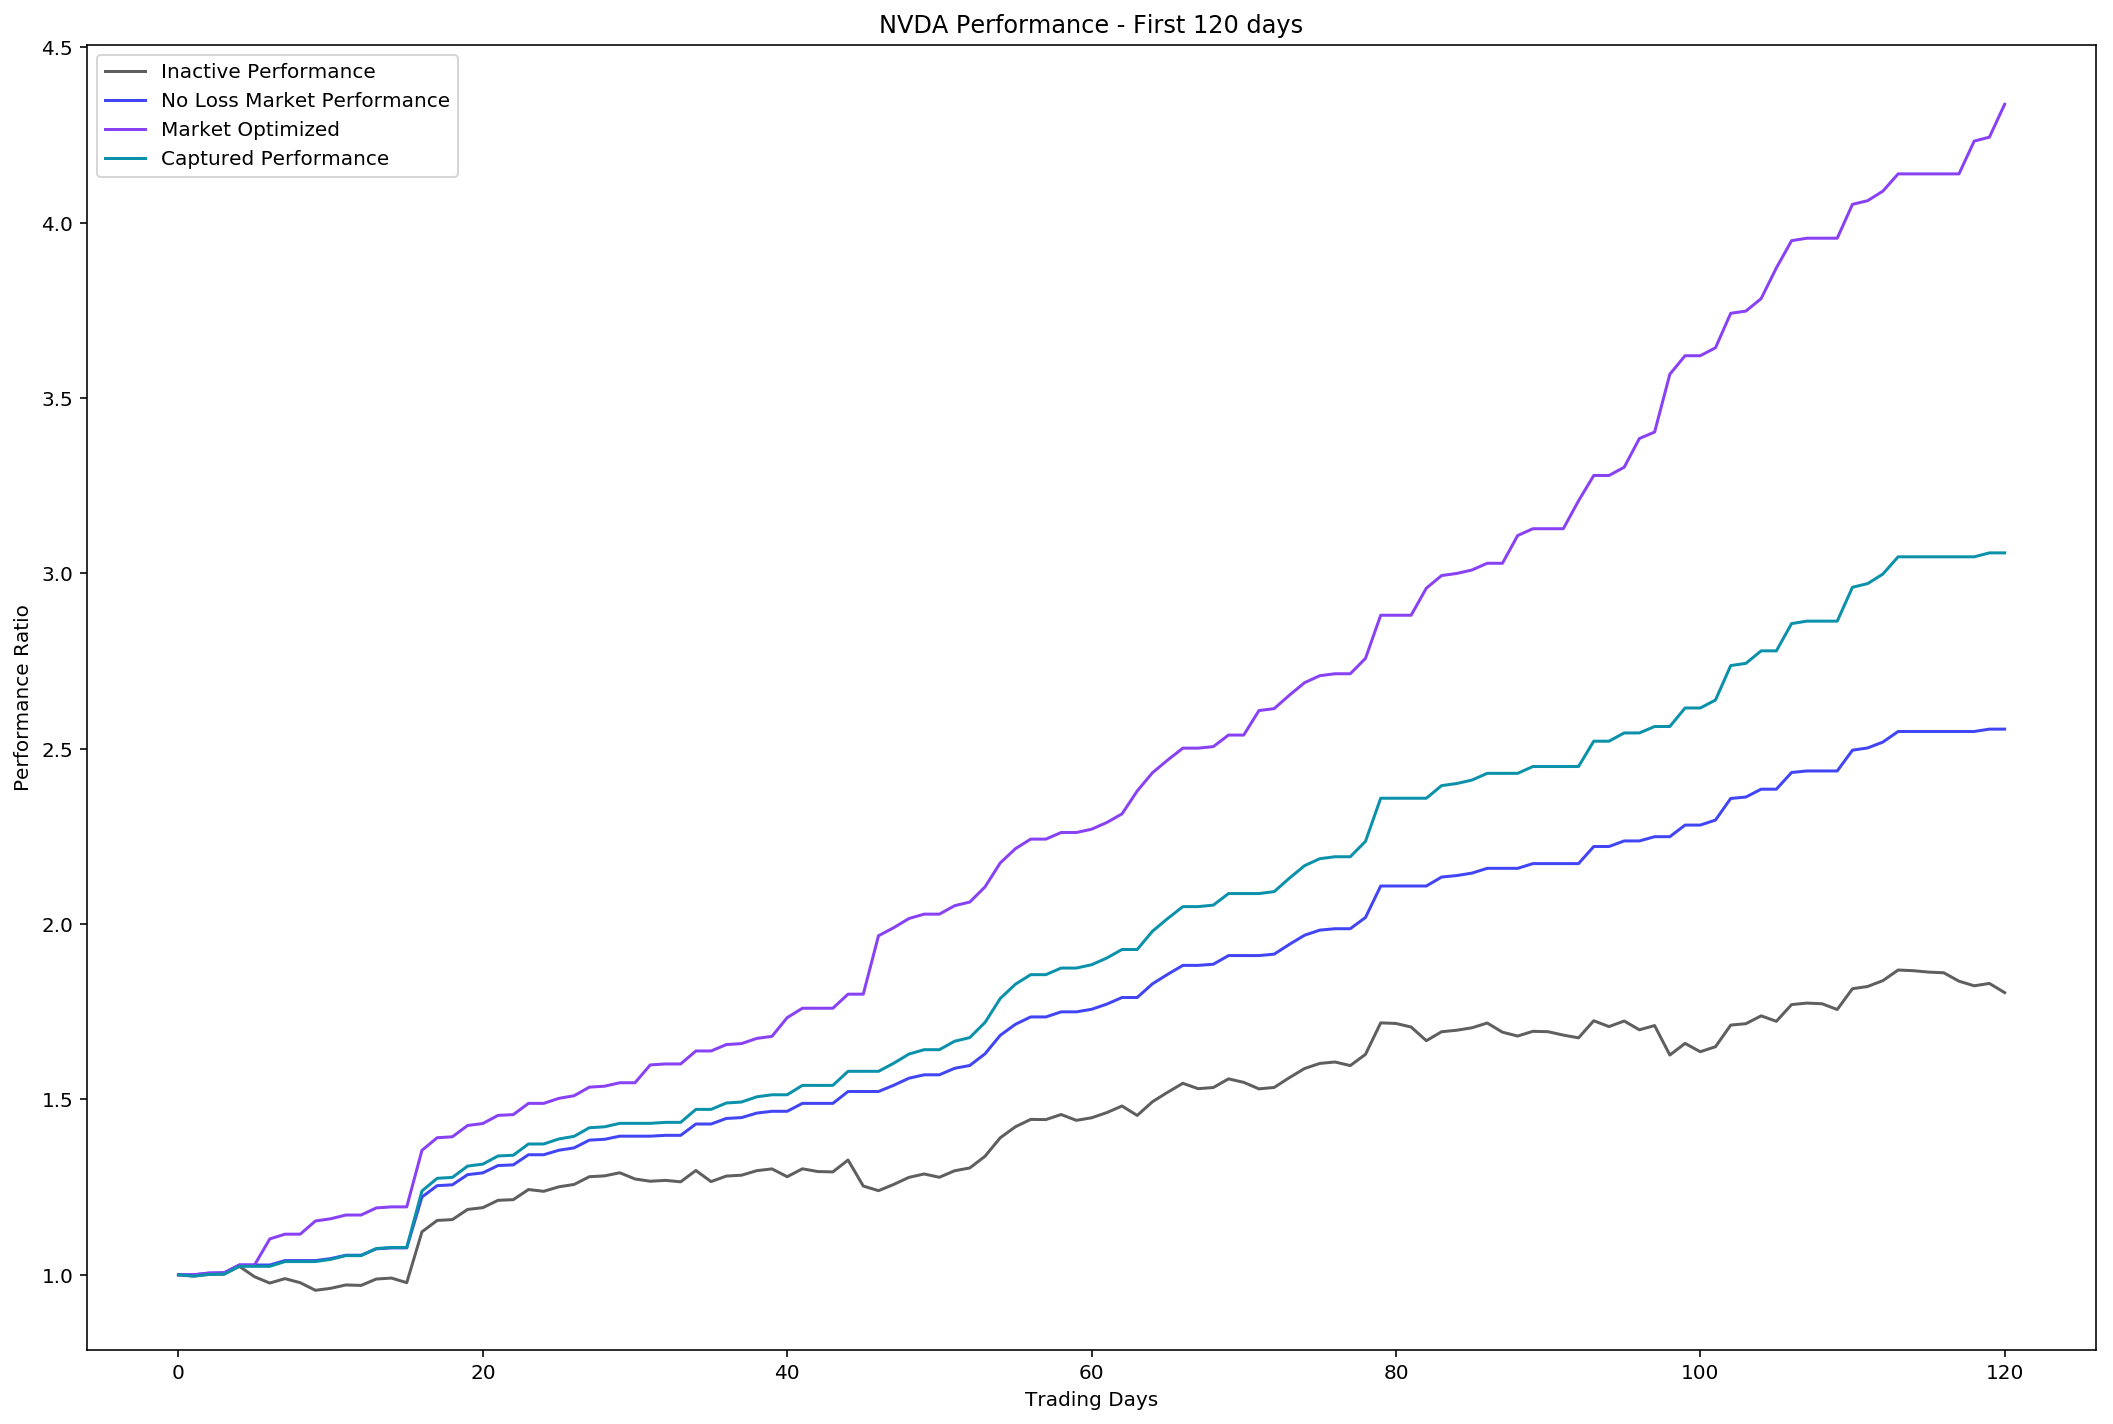

In [19]:
# Plot the performance metrics first 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Performance Ratio')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[:120,'InactivePerform'],'#5F5F5F', label='Inactive Performance')
plt.plot(trades_df.loc[:120,'NoLossMarketPerform'], '#4245f4', label='No Loss Market Performance')
plt.plot(trades_df.loc[:120,'MarketOptPerform'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[:120,'Performance'], '#0C91AB', label='Captured Performance')

# Set title
ax.set_title(base_ticker + ' Performance - First 120 days')
ax.legend(loc='upper left')

# Log of Results:
Epochs: 5 Lookback: 1 

### TSLA
Test Score: 0.001255 MSE (0.035425 RMSE)

Delta Price: 0.178667 - RMSE * Adjusted Close Range


### AMZN
Test Score: 0.001190 MSE (0.034493 RMSE)

Delta Price: 0.713370 - RMSE * Adjusted Close Range

### GOOG
Test Score: 0.000658 MSE (0.025651 RMSE)

Delta Price: 0.236584 - RMSE * Adjusted Close Range

### NVDA
Test Score: 0.000861 MSE (0.029351 RMSE)

Delta Price: 0.088481 - RMSE * Adjusted Close Range